# Unconditional sampling from $\mathbb{G}$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

class Unconditional(object):
    def __init__(self, dimension, generator, latent_size, latent_dist, use_cuda=False):
        self.use_cuda = use_cuda

        self.dimension = dimension
        self.generator = generator

        if self.use_cuda:
            self.generator = self.generator.cuda()

        self.latent_size = latent_size
        self.latent_dist = latent_dist

    def sample_batch(self, batch, m):
        config = [batch, self.latent_size]# + m
        zhat = None
        if self.use_cuda:
            zhat = Variable(torch.FloatTensor(*config).cuda(), requires_grad=True)
        else:
            zhat = Variable(torch.FloatTensor(*config), requires_grad=True)
        zhat.retain_grad()
        if self.latent_dist == "normal":
            zhat.data = zhat.data.normal_(0, 1)
        elif self.latent_dist == "uniform":
            zhat.data = zhat.data.uniform_(-1, 1)
        return zhat

    def create_unconditional_simulations(self, batch, m):
        zhat = self.sample_batch(batch, m)
        if self.use_cuda:
            zhat = zhat.cuda()
        try:
            xhat = self.generator(zhat)
            return xhat.data.cpu().numpy()
        except RuntimeError as reError:
            print(reError)

In [2]:
import os
import cv2
import yaml
import time
import torch
import shutil
import torchvision
import tensorboardX
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
from imageio import imsave
from torch.autograd import grad
from torch.autograd import Variable
from skimage.util import view_as_windows


"""
WGAN-GP implementation.

This is an implementation of Wasserstein GANs with gradient penalty.
Link to the paper is : https://arxiv.org/pdf/1704.00028.pdf

Wasserstein GANs suggest a change in the distance function calculated while
 training any Generative Adverserial Network.
"""


class GeneratorModel(nn.Module):
    """
    Generator model for WGAN-GP.

    Given a vector of random values (latent inputs) as input, this network
    generates data with the same structure as the training data.
    The goal is to train the generator to generate data that "fools" the
    Critic.
    """

    def __init__(self, dim_in, dim: int = 128):
        super(GeneratorModel, self).__init__()

        def genblock(dim_in, dim_out):
            
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=dim_out,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     bias=False),
                                  nn.BatchNorm2d(dim_out),
                                  nn.ReLU()
                                  )
            return block

        def genimg(dim_in):
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=1,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     ),
                                  nn.Tanh()
                                  )
            return block

        self.prepare = nn.Sequential(nn.Linear(dim_in, dim*8*4*4, bias=False),
                                     nn.BatchNorm1d(dim*8*4*4),
                                     nn.ReLU())
        self.generate = nn.Sequential(genblock(dim*8, dim*16),
                                      genblock(dim*16, dim*8),
                                      genblock(dim*8, dim*4),
                                      genblock(dim*4, dim*2),
                                      genimg(dim*2))

    def forward(self, x):
        """Forward pass function."""
        x = self.prepare(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.generate(x)
        return x

latent_size = 100

state_dict = torch.load(r"C:\Users\algocompretto\PycharmProjects\gan-for-mps\Epoch_50.ckpt", map_location='cpu')

generator = GeneratorModel(latent_size)
generator.load_state_dict(state_dict["Generator"])

<All keys matched successfully>

In [4]:
uncond = Unconditional(1, generator, latent_size, "normal")
x = 1
for i in range(1):
    samples = uncond.create_unconditional_simulations(100, [i, i, i])
    if samples is not None:
        print("Imsize: ", i, "Uncoditional Simulation Size: ", samples.shape)
samples_arr = np.where(np.concatenate(samples, 0)*0.5+0.5 >= 0.5, 1.0, 0.0)
#np.save("generative_mps/results/array_generated", samples_arr, allow_pickle=True)

Imsize:  0 Uncoditional Simulation Size:  (100, 1, 128, 128)


In [48]:
for im in samples_arr:
        try:
                dataset = np.loadtxt(f"gan_bin/gan_results.out")
                im = cv2.resize(im, (150, 150))
                im = np.where(im > 0.5, 1, 0)
                numpy_tensor = im.squeeze().ravel()
                new_TI = np.column_stack((dataset, numpy_tensor))
                np.savetxt(fname = "gan_results.out",
                        X = new_TI,
                        newline = os.linesep,
                        header=f"150 150 1\n"
                                "1\n"
                                "facies\n")
                new_TI = np.column_stack((dataset, numpy_tensor))
        except FileNotFoundError:
                im = cv2.resize(im, (150, 150))
                im = np.where(im > 0.5, 1, 0)
                numpy_tensor = im.squeeze().ravel()
                np.savetxt(fname = f"gan_bin/gan_results.out",
                        X=numpy_tensor,
                        newline = os.linesep,
                        header=f"150 150 1\n"
                                "1\n"
                                "facies\n")

In [50]:
numpy_array = np.loadtxt("gan_bin/gan_results.out")
header_name = [f'ti_{idx}' for idx in range(numpy_array.reshape(150,150).shape[0])]
header_name = f'\n'.join(header_name)

# Save again with header
np.savetxt(fname="gan_bin/gan_results.out",
            X=numpy_array,
            header=f"gan_results\n{numpy_array.reshape(150,150).shape[1]}\n{header_name}", comments="")

# SNESIM simulation

In [51]:
import os

os.makedirs("gan_bin/out_files", exist_ok=True)
os.makedirs("gan_bin/simulations", exist_ok=True)

for idx, im in enumerate(samples_arr):
    im = cv2.resize(im, (150,150))
    image_resized = np.where(im > 0.5, 1, 0)

    # save as .out
    np.savetxt(f"gan_bin/out_files/ti_{idx}.out", image_resized.reshape(-1), header="150 150 1\n1\nfacies", fmt="%1d",comments='')

## Fix this

In [6]:
# Powershell script to run simulations
# for($i = 0; $i -lt 100; $i++){
#     echo "___ SIMULATION $i ___"
#     echo "snesim_gan.par" | .\snesim.exe
#     [int]$sum = [int]$i+1
#     ((Get-Content -path snesim_gan.par -Raw) -replace "snesim_$i.out","snesim_$sum.out") | Set-Content -Path snesim_gan.par
#     ((Get-Content -path snesim_gan.par -Raw) -replace "ti_$i.out", "ti_$sum.out") | Set-Content -Path snesim_gan.par
# }
print("Done simulations")

Done simulations


## Loading SNESIM data from $\mathbb{G}$

In [52]:
import numpy
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from src.helpers.funcs import *

plt.style.use(["science", "nature"])

import matplotlib
plt.rcParams.update({
    "text.usetex": False})

In [53]:
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def highlight_cell(x_coordinate, y_coordinate, axis=None, **kwargs):
    rect = plt.Rectangle((x_coordinate - .5, y_coordinate - .5), 1, 1, fill=True, **kwargs)
    axis = axis or plt.gca()
    axis.add_patch(rect)
    return rect

def get_color_bar():
    cmap = mpl.colors.ListedColormap(['white', "black"])

    col_dict={0:"white", 1:"black"}
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

    norm = mpl.colors.BoundaryNorm(norm_bins, 2, clip=True)

    labels = np.array(["Sandstone", "Shale"])
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2

    colorbar = plt.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        ticks=tickz,
        format=fmt,
        spacing='proportional',
        label='Facies',
    )

    return colorbar

def etype_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

    # Get mean for each row
    _data['etype'] = _data.mean(axis=1)
    ax.imshow(_data['etype'].values.reshape(150, 150),
              cmap='gray', origin='lower')

    # Text settings
    plt.title("Etype of SNESIM with generated TIs")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")

    # Colorbar settings
    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params()
    cb.set_label("Mean")

    # Saving images to .pdf format
    plt.grid(False)
    #plt.savefig("generative_mps/results/etype.pdf", dpi=600, bbox_inches="tight")
    #plt.savefig("generative_mps/results/etype.png", dpi=600, bbox_inches='tight')
    plt.show()

def calculate_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    _data['prob_sand'] = _data.sum(axis=1)
    _data['prob_shale'] = 100 - _data['prob_sand']

    _data["u_max"] = _data[["prob_shale", "prob_sand"]].max(axis=1) / 100
    _data["u_min"] = _data[["prob_shale", "prob_sand"]].min(axis=1) / 100

    _data.drop('prob_sand', axis=1, inplace=True)
    _data.drop('prob_shale', axis=1, inplace=True)

    return _data

def plot_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(5.5, 4))

    _data = calculate_uncertainty(_data)

    plt.imshow(_data['u_min'].values.reshape(150, 150),
              cmap='gray', origin='lower')

    plt.title("Simulation uncertainty from proposed workflow")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")

    # Colorbar settings
    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', spacing="proportional")
    cb.ax.tick_params()
    cb.set_label("Uncertainty")

    # Saving images to .pdf format
    plt.grid(False)
    ##plt.savefig('generative_mps/results/uncertainty.pdf', dpi=500, bbox_inches="tight")
    ##plt.savefig("generative_mps/results/uncertainty.png", dpi=600, bbox_inches='tight')
    plt.show()


def plot_realizations_grid(real):
    # Samples 25 TI for a grid of 5x5 images
    rand_idx = [random.randint(0, 99) for _ in range(9)]
    tis_sampled = [real[i] for i in rand_idx]

    fig = plt.figure(figsize=(8, 5))

    image_grid = ImageGrid(fig, 111,
                           nrows_ncols=(3, 3),
                           axes_pad=0.1,
                           cbar_location="left",
                           cbar_pad=0.15)

    cb = get_color_bar()

    fig.suptitle("SNESIM realizations from Generative model")

    for ax, image in zip(image_grid, tis_sampled):
        # Iterating over the grid returns the Axes.
        ax.imshow(image, cmap="gray", origin="lower")

    #plt.savefig("generative_mps/results/simulation_grid.pdf", dpi=600,
                #bbox_inches="tight")
    #plt.savefig("generative_mps/results/simulation_grid.png", dpi=600, bbox_inches='tight')
    plt.show()

def get_sand_shale_proportion(image):
    image = image.reshape(-1)
    sand_prop = (len(np.where(image==1)[0]) / 150**2)*100
    shale_prop = (len(np.where(image==0)[0]) / 150**2)*100
    return sand_prop, shale_prop

def proportions(real: numpy.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(5.5, 4))

    sand_values = list()
    shale_values = list()

    # Get proportions for all
    for i in range(1, len(real)):
        sand, shale = get_sand_shale_proportion(real[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax.boxplot(df, labels=["Sandstone", "Shale"], patch_artist=True,
                    showmeans=True, showfliers=False)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    plt.ylim(20, 80)

    plt.ylabel('Percentage (%)')
    plt.xlabel('Category')
    plt.title('SNESIM Generated Training Images proportions')

    #plt.savefig("generative_mps/results/boxplot_snesim.pdf", dpi=600,
                #bbox_inches='tight')

    #plt.savefig("generative_mps/results/boxplot_snesim.png", dpi=600, bbox_inches='tight')

    plt.show()

def concatenate_out_files(directory: str):
    cat_array = []
    for im in os.listdir(directory):
        image = np.loadtxt(directory+im, skiprows=4)[:,0]
        cat_array.append(np.resize(image, (150, 150)))
    return cat_array

In [54]:
print("[INFO] Loading simulations", end="\r")
realizations = concatenate_out_files("gan_bin/simulations/")

ti_dict = dict()
for idx, realization in enumerate(realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

dataframe = pd.DataFrame(ti_dict)

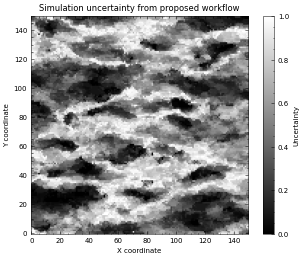

In [55]:
plot_uncertainty(dataframe)

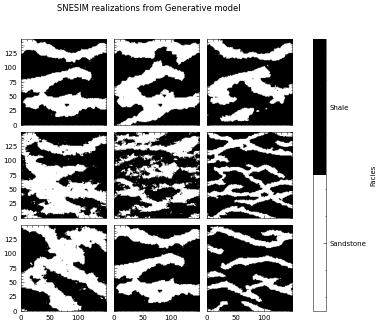

In [56]:
plot_realizations_grid(realizations)

eas: file ->snesim/data/snesim_150x150.out
eas: title-> SNESIM Realizations


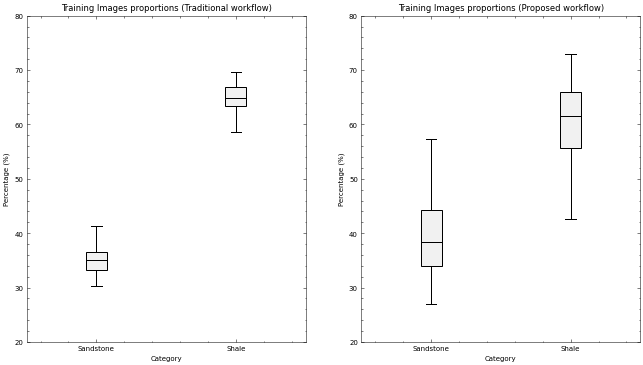

In [57]:
file = read_conditional_samples("snesim/data/snesim_150x150.out")["D"]
realizations = file[:, 0].reshape(100, 150, 150)

print("[INFO] Loading simulations", end="\r")
snesim_gen_realizations = concatenate_out_files("gan_bin/simulations/")

def proportions_comparison(real: numpy.ndarray, fake:numpy.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 6))

    sand_values = list()
    shale_values = list()

    # Get proportions for real data
    for i in range(1, len(real)):
        sand, shale = get_sand_shale_proportion(real[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax[0].boxplot(df, labels=["Sandstone", "Shale"],
                       patch_artist=True, showfliers=False)
    ax[0].set_ylabel('Percentage (%)')
    ax[0].set_xlabel('Category')
    ax[0].set_title('Training Images proportions (Traditional workflow)')

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    sand_values = list()
    shale_values = list()
    # Get proportions for fake data
    for i in range(1, len(fake)):
        sand, shale = get_sand_shale_proportion(fake[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax[1].boxplot(df, labels=["Sandstone", "Shale"],
                       patch_artist=True, showfliers=False)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    ax[0].set_ylim(20, 80)
    ax[1].set_ylim(20, 80)

    ax[1].set_ylabel('Percentage (%)')
    ax[1].set_xlabel('Category')
    ax[1].set_title('Training Images proportions (Proposed workflow)')

    #plt.savefig("generative_mps/results/boxplot_snesim.pdf", dpi=600,
                #bbox_inches='tight')

    #plt.savefig("generative_mps/results/boxplot_snesim.png", dpi=600, bbox_inches='tight')

    plt.show()

proportions_comparison(realizations,
                       snesim_gen_realizations)